In [1]:
import pandas as pd
import numpy as np
from scipy import stats


#Cleaning CDI Data
CDI_raw = pd.read_csv("/Users/abbyhultquist/Documents/First Year Project/CDI_raw.csv")
CDI = CDI_raw.copy()

print("Initial CDI shape:", CDI.shape)
CDI = CDI.sort_values(['child_id', 'session_num'])

Initial CDI shape: (1167, 699)


In [2]:
#creating a list of ALL words 
word_cols = CDI.columns[19:].tolist()
metadata_cols = CDI.columns[:19].tolist()

print("total # words considered:", len(word_cols))

# Calculate initial vocab_size
CDI['vocab_size'] = CDI[word_cols].sum(axis=1) #axis  = 1 means sum across columns for each row



total # words considered: 680


In [4]:
#OUTLIER DETECTION
# < 4 sessions
session_counts = CDI.groupby('child_id')['session_num'].count()
outliers_few_sessions = set(session_counts[session_counts < 4].index)

print(f"<4 sessions: {len(outliers_few_sessions)} children")

# Any session > 12
max_session = CDI.groupby('child_id')['session_num'].max()
outliers_session13 = set(max_session[max_session > 12].index)

print(f"Session >12: {len(outliers_session13)} children")

# Explicit vocab cutoff
vocab_cutoff = 700
outliers_cutoff = set(
    CDI.loc[CDI['words_spoken'] > vocab_cutoff, 'child_id']
)

print(f"Vocab > {vocab_cutoff}: {len(outliers_cutoff)} children")

# Z-score outliers
z = np.abs(stats.zscore(CDI['words_spoken'], nan_policy='omit'))
outliers_z = set(CDI.loc[z > 3, 'child_id'])

print(f"|z| > 3: {len(outliers_z)} children")


# Combine & remove

all_outliers = (
    outliers_few_sessions
    | outliers_session13
    | outliers_cutoff
    | outliers_z
)

print(f"\nTOTAL unique children removed: {len(all_outliers)}")

CDI = CDI[~CDI['child_id'].isin(all_outliers)].copy()

print(f"Final dataset shape: {CDI.shape}")
print(f"Number of unique children: {CDI['child_id'].nunique()}")





<4 sessions: 0 children
Session >12: 0 children
Vocab > 700: 0 children
|z| > 3: 0 children

TOTAL unique children removed: 0
Final dataset shape: (1141, 700)
Number of unique children: 110


In [5]:

# Convert to numeric, fill NaN with 0, then set any value >=1 to 1
CDI[word_cols] = CDI[word_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
CDI[word_cols] = (CDI[word_cols] >= 1).astype(int)

# Recompute vocab counts with binary values
CDI['vocab_size'] = CDI[word_cols].sum(axis=1)

print("After binarization:")
print("len(word_cols) =", len(word_cols))
print("max vocab_size =", CDI['vocab_size'].max())


After binarization:
len(word_cols) = 680
max vocab_size = 680


In [6]:
#Once a word is learned, it stays learned
grouped = CDI.groupby('child_id')
for child_id, group in grouped:
    group = group.sort_values('session_num')
    for word in word_cols:
        # Find first session where word is known
        known_sessions = group[group[word] == 1]['session_num']
        if not known_sessions.empty:
            first_known = known_sessions.min()
            # Set word as known from first_known onwards
            CDI.loc[(CDI['child_id'] == child_id) & (CDI['session_num'] >= first_known), word] = 1
# Update words_spoken to reflect the cumulative knowledge
CDI['words_spoken'] = CDI[word_cols].sum(axis=1)

#check maximum vocab_size after cumulative knowledge enforcement
print()
print("After enforcing cumulative knowledge")
print("Sample vocab_size stats:", CDI['vocab_size'].describe())
print("Sample words_spoken stats:", CDI['words_spoken'].describe())
print(max(CDI['vocab_size']), max(CDI['words_spoken']))

# Also update vocab_size
CDI['vocab_size'] = CDI['words_spoken']

print()
print("After ensuring cumulative knowledge and recalculating vocab_size")
print("Sample vocab_size stats:", CDI['vocab_size'].describe())
print("Updated words_spoken to match cumulative vocab_size")


After enforcing cumulative knowledge
Sample vocab_size stats: count    1141.000000
mean      310.142857
std       218.884953
min         0.000000
25%       101.000000
50%       292.000000
75%       510.000000
max       680.000000
Name: vocab_size, dtype: float64
Sample words_spoken stats: count    1141.000000
mean      318.740578
std       221.441357
min         0.000000
25%       103.000000
50%       305.000000
75%       523.000000
max       680.000000
Name: words_spoken, dtype: float64
680 680

After ensuring cumulative knowledge and recalculating vocab_size
Sample vocab_size stats: count    1141.000000
mean      318.740578
std       221.441357
min         0.000000
25%       103.000000
50%       305.000000
75%       523.000000
max       680.000000
Name: vocab_size, dtype: float64
Updated words_spoken to match cumulative vocab_size


In [7]:
import numpy as np

percentile_threshold = 20 

CDI = CDI.sort_values(['child_id', 'session_num'])
talker_dict = {}
for child_id, group in CDI.groupby('child_id'):

    early = group[group['session_num'].between(1,3)]
    early_vals = early['percentile']
    early_vals = early_vals[early_vals != 0]
    early_mean = early_vals.mean()

    late = group[group['session_num'].between(9,12)]
    late_vals = late['percentile']
    late_vals = late_vals[late_vals != 0]
    late_mean = late_vals.mean()

    # Skip if no usable data
    if np.isnan(early_mean) or np.isnan(late_mean): #removing kids that dont have data in early or late
        continue

    lt_early = early_mean < percentile_threshold 
    lt_late = late_mean < percentile_threshold

    if lt_early and lt_late:
        talker_type = 'PLT'
    elif lt_early and not lt_late:
        talker_type = 'LB'
    elif not lt_early and not lt_late:
        talker_type = 'TT'
    else:
        talker_type = 'Faller'

    talker_dict[child_id] = talker_type

# Count from dictionary
counts = pd.Series(talker_dict).value_counts()
print(counts)
print("Total classified:", counts.sum())

CDI['Talker_Type'] = CDI['child_id'].map(talker_dict)
print("Children classified:", len(talker_dict))
print("Unique children in data:", CDI['child_id'].nunique())


TT        63
LB        25
PLT        7
Faller     1
Name: count, dtype: int64
Total classified: 96
Children classified: 96
Unique children in data: 110


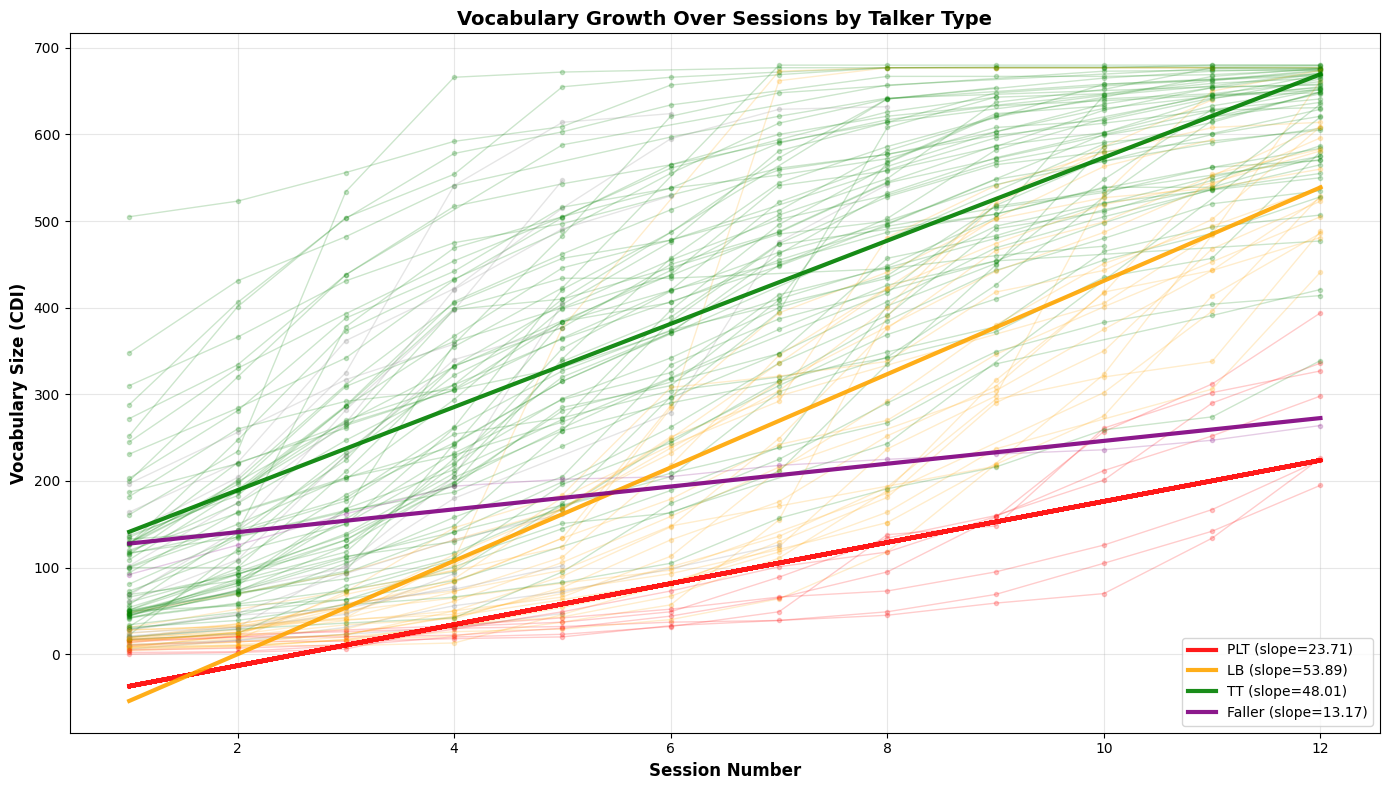

Plot saved as CDI_vocab_growth_trajectories.png


In [28]:
# Plot vocabulary size growth over sessions with trend lines by talker type
import matplotlib.pyplot as plt
from scipy import stats as sp_stats

color_map = {'PLT': 'red', 'LB': 'orange', 'TT': 'green', 'Faller': 'purple'}

fig, ax = plt.subplots(figsize=(14, 8))

# Plot individual trajectories
for child_id, group in CDI.groupby('child_id'):
    group = group.sort_values('session_num')
    talker_type = group['Talker_Type'].iloc[0]
    color = color_map.get(talker_type, 'gray')
    
    ax.plot(group['session_num'], group['vocab_size'], 
            color=color, alpha=0.2, linewidth=1, marker='o', markersize=3)

# Add trend lines for each talker type
for talker_type in ['PLT', 'LB', 'TT', 'Faller']:
    group_data = CDI[CDI['Talker_Type'] == talker_type]
    if len(group_data) == 0:
        continue
    
    # Prepare data for trendline
    x = group_data['session_num'].values
    y = group_data['vocab_size'].values
    
    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = sp_stats.linregress(x, y)
    line = slope * x + intercept
    
    # Plot trendline
    color = color_map.get(talker_type, 'gray')
    ax.plot(x, line, color=color, linewidth=3, alpha=0.9, 
            label=f'{talker_type} (slope={slope:.2f})')
    
ax.set_xlabel('Session Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Vocabulary Size (CDI)', fontsize=12, fontweight='bold')
ax.set_title('Vocabulary Growth Over Sessions by Talker Type', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('CDI_vocab_growth_trajectories.png', dpi=300)
plt.show()

print("Plot saved as CDI_vocab_growth_trajectories.png")

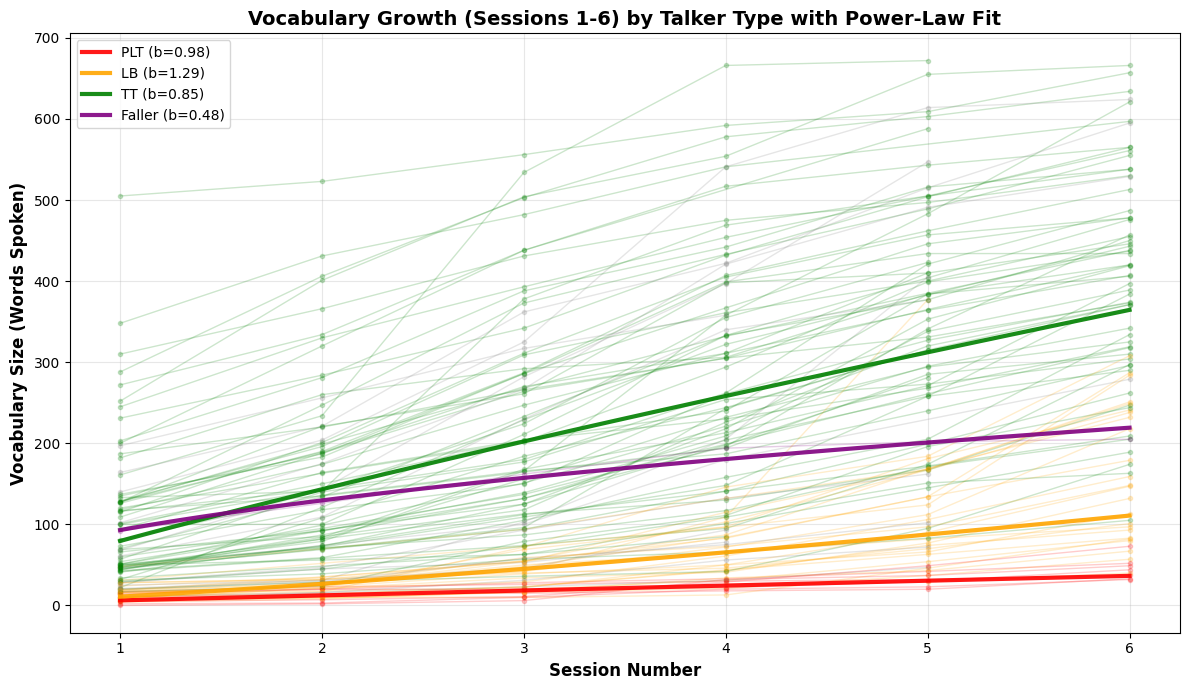

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sp_stats

# Restrict to sessions 1-6
CDI_subset = CDI[CDI['session_num'].between(1, 6)].copy()

color_map = {'PLT': 'red', 'LB': 'orange', 'TT': 'green', 'Faller': 'purple'}

fig, ax = plt.subplots(figsize=(12, 7))

# Plot individual trajectories
for child_id, group in CDI_subset.groupby('child_id'):
    group = group.sort_values('session_num')
    talker_type = group['Talker_Type'].iloc[0]
    color = color_map.get(talker_type, 'gray')
    
    ax.plot(group['session_num'], group['vocab_size'], 
            color=color, alpha=0.2, linewidth=1, marker='o', markersize=3)

# Add power-law trend lines for each talker type
for talker_type in ['PLT', 'LB', 'TT', 'Faller']:
    group_data = CDI_subset[CDI_subset['Talker_Type'] == talker_type].copy()
    if len(group_data) == 0:
        continue
    
    # Remove zeros for log transform
    group_data = group_data[
        (group_data['session_num'] > 0) & 
        (group_data['vocab_size'] > 0)
    ]
    
    x = group_data['session_num'].values
    y = group_data['vocab_size'].values
    
    # Log-log regression
    log_x = np.log(x)
    log_y = np.log(y)
    slope, intercept, r_value, p_value, std_err = sp_stats.linregress(log_x, log_y)
    
    # Convert back to power-law parameters
    b = slope
    a = np.exp(intercept)
    
    # Smooth curve for plotting
    x_line = np.linspace(1, 6, 100)
    y_line = a * (x_line ** b)
    
    color = color_map.get(talker_type, 'gray')
    ax.plot(x_line, y_line, color=color, linewidth=3, alpha=0.9,
            label=f'{talker_type} (b={b:.2f})')

ax.set_xlabel('Session Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Vocabulary Size (Words Spoken)', fontsize=12, fontweight='bold')
ax.set_title('Vocabulary Growth (Sessions 1-6) by Talker Type with Power-Law Fit', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


In [18]:
import statsmodels.formula.api as smf
import numpy as np

# Restrict sessions 1-6 and positive values
CDI_subset = CDI[CDI['session_num'].between(1, 6)].copy()
CDI_subset = CDI_subset[(CDI_subset['vocab_size'] > 0)]

# Add log-transformed variables
CDI_subset['log_vocab'] = np.log(CDI_subset['vocab_size'])
CDI_subset['log_session'] = np.log(CDI_subset['session_num'])

model = smf.ols('log_vocab ~ log_session', data=CDI_subset).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:              log_vocab   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     207.0
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           9.08e-41
Time:                        10:06:56   Log-Likelihood:                -903.44
No. Observations:                 629   AIC:                             1811.
Df Residuals:                     627   BIC:                             1820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.6814      0.083     44.436      